# 3.1 - Training

- We'll be using `Ray` to train our model on a cluster of different machines (however this will be simulated on a single machine).

In [1]:
import openai
from dotenv import load_dotenv; load_dotenv()
import os

OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")

In [2]:
import pandas as pd
#load training data
DATASET_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/dataset.csv"
train_df = pd.read_csv(DATASET_LOC)
train_df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",other
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,other
4,25,2020-03-07 23:04:31,AttentionWalk,"A PyTorch Implementation of ""Watch Your Step: ...",other


In [3]:
#Unique labels
tags=train_df['tag'].unique().tolist()
tags

['computer-vision', 'other', 'natural-language-processing', 'mlops']

In [4]:
#Load inference dataset
HOLDOUT_LOC = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/holdout.csv"
test_df=pd.read_csv(HOLDOUT_LOC)

## Utilities

- Define a few utility functions to make the openAI API calls easier to use, and to store our predictions.

In [5]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support
import time
from tqdm import tqdm
from openai import OpenAI

In [6]:
#setup openAI api call
client=OpenAI(api_key=OPENAI_API_KEY)
response=None

In [7]:
system_content='You only answer in rhymes'
user_content='How are you' #user content (message)

if (response == None):
    response=client.responses.create(
        model='gpt-3.5-turbo',
        instructions=system_content,
        input=user_content
    )
else:
    print(response.output_text)

In [8]:
def get_tag(model:str,prompt_system: str,prompt_user:str):
  try:
    res=client.responses.create(
        model=model,
        instructions=prompt_system,
        input=prompt_user
    )
    return res.to_dict()['output'][0]['content'][0]['text']
  except (openai.APIError) as e:
    print('API Error')
    return None
  except:
    print(f"Catch all exception occurred.")
    return None

In [9]:
#get tag
response=''
model = "gpt-4.1-nano-2025-04-14"
system_context:str = f"""
    You are a NLP prediction service that predicts the label given an input's title and description.
    You must choose between one of the following labels for each input: {tags}.
    Only respond with the label name and nothing else.
    """
user_context:str = "Transfer learning with transformers: Using transformers for transfer learning on text classification tasks."
tag:str = get_tag(model=model, prompt_system=system_context, prompt_user=user_context)
print (tag)

natural-language-processing


In [10]:
samples=test_df[['title','description']].to_dict(orient='records')[:3]
samples

[{'title': 'Diffusion to Vector',
  'description': 'Reference implementation of Diffusion2Vec (Complenet 2018) built on Gensim and NetworkX. '},
 {'title': 'Graph Wavelet Neural Network',
  'description': 'A PyTorch implementation of "Graph Wavelet Neural Network" (ICLR 2019) '},
 {'title': 'Capsule Graph Neural Network',
  'description': 'A PyTorch implementation of "Capsule Graph Neural Network" (ICLR 2019).'}]

In [11]:
import time
def get_predictions(inputs,model,system_content):
  y_pred=[]
  for item in tqdm(inputs):
    #Convert item dict to string
    user_content=str(item)

    #get prediciton
    predicted_tag=get_tag(model=model,prompt_system=system_content,prompt_user=user_content)

    #if error try again after a pause (repeat until success)
    while predicted_tag is None:
      time.sleep(1)
      predicted_tag=get_tag(model=model,prompt_system=system_content,prompt_user=user_content)

    #append prediction
    y_pred.append(predicted_tag)
  return y_pred

In [12]:
#get predictions for a list of inputs
y_pred=get_predictions(inputs=samples,model=model,system_content=system_context)
y_pred

100%|██████████| 3/3 [00:01<00:00,  2.03it/s]


['mlops', 'computer-vision', 'machine-vision']

In [13]:
def clean_predictions(y_pred,tags,default='other'):
  for i, item in enumerate(y_pred):
    if item not in tags:
      y_pred[i]=default
    if item.startswith("'") and item.endswith("'"):
      y_pred[i]=item[1:-1]
  return y_pred
#clean predictions
y_pred=clean_predictions(y_pred=y_pred,tags=tags)
y_pred

['mlops', 'computer-vision', 'other']

In [14]:
def plot_tag_dist(y_true,y_pred):
  #count number of true and predicted tags
  true_tag_freq=dict(Counter(y_true))
  pred_tag_freq=dict(Counter(y_pred))
  #get truth from dfs
  df_true=pd.DataFrame({"tag":list(true_tag_freq.keys()),"freq":list(true_tag_freq.values()), "source":"truth"})
  df_pred=pd.DataFrame({"tag":list(pred_tag_freq.keys()),"freq":list(pred_tag_freq.values()), "source":"pred"})
  df=pd.concat([df_true,df_pred],ignore_index=True)
  #rotate x-axis labels
  plt.xticks(rotation=90)
  sns.barplot(x="tag",y="freq",data=df,hue="source")
  plt.show()

In [15]:
def evaluate(test_df,model,system_content,assistant_content='',tags=''):
  #predictions
  y_test=test_df.tag.tolist()
  test_samples=test_df[['title','description']].to_dict(orient='records')
  y_pred=get_predictions(inputs=test_samples,model=model,system_content=system_content)

  #performance
  metrics=precision_recall_fscore_support(y_test,y_pred,average='weighted')
  performance={'precision':metrics[0],'recall':metrics[1],'f1':metrics[2]}
  print(json.dumps(performance,indent=4))
  plot_tag_dist(y_true=y_test,y_pred=y_pred)
  return y_pred,performance


### Start benchmarking

- We start with zero-shot predictions, which involves providing the model with the `system_content` only.
    - This will show us the performance of the model if we don't provide any examples.

In [16]:
y_pred={'zero_shot':{},"few_shot":{}}
performance={'zero_shot':{},"few_shot":{}}

In [17]:
system_content=f"""
You are a NLP prediction service that predicts the label given an input's title and description.
You must choose between one of the following labels for each input: {tags}.
Only respond with the label name and nothing else.
"""

100%|██████████| 191/191 [01:51<00:00,  1.71it/s]

{
    "precision": 0.7401770910271409,
    "recall": 0.7905759162303665,
    "f1": 0.7525363836811878
}


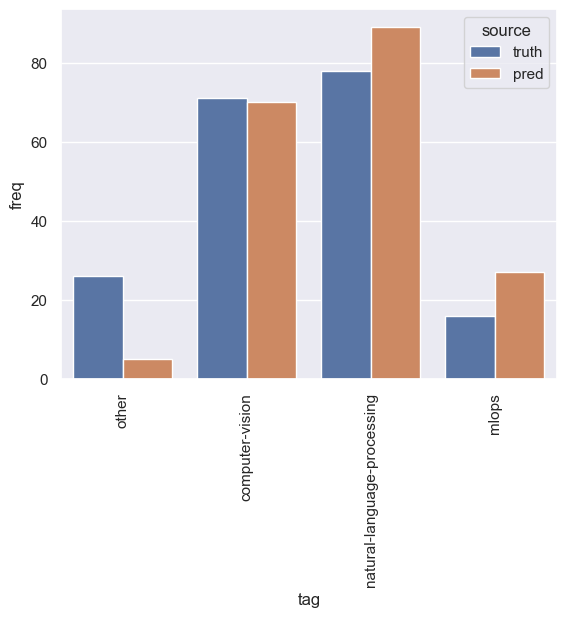

In [18]:
#zero shot with gpt 4.1-nano-2025-04-14
method='zero_shot'
model='gpt-4.1-nano-2025-04-14'
y_pred[method][model],performance[method][model]=evaluate(test_df=test_df,model=model,system_content=system_content,tags=tags)

100%|██████████| 191/191 [02:36<00:00,  1.22it/s]

{
    "precision": 0.9015028524498804,
    "recall": 0.8324607329842932,
    "f1": 0.847166534816448
}


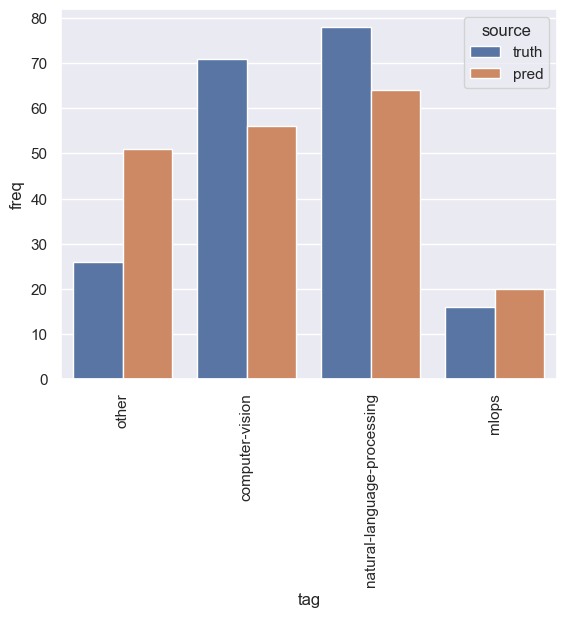

In [19]:
#zero shot with gpt 4o-mini
method='zero_shot'
model='gpt-4o-mini-2024-07-18'
y_pred[method][model],performance[method][model]=evaluate(test_df=test_df,model=model,system_content=system_content,tags=tags)

### Few Shot Learning

- Next, we'll use few-shot learning to see if we can improve the performance of the model.
    - We'll provide the model with a few examples of the correct label.
    - This will help the model to learn the correct label.



In [20]:
#create additional context with few samples from each class
num_samples=2
additional_context=[]
cols_to_keep=['title','description','tag']
for tag in tags:
  samples=train_df[cols_to_keep][train_df.tag==tag][:num_samples].to_dict(orient='records')
  additional_context.extend(samples)

#convert to string
additional_context_str='\n'.join([str(item) for item in additional_context])
additional_context_str

"{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}\n{'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\\n', 'tag': 'computer-vision'}\n{'title': 'Awesome Graph Classification', 'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.', 'tag': 'other'}\n{'title': 'Awesome Monte Carlo Tree Search', 'description': 'A curated list of Monte Carlo tree search papers with implementations. ', 'tag': 'other'}\n{'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhibit large variance throughout training, which le

In [21]:
assistant_content=f"""
Here are some examples of the correct label:
{additional_context_str}
"""
print(assistant_content)


Here are some examples of the correct label:
{'title': 'Comparison between YOLO and RCNN on real world videos', 'description': 'Bringing theory to experiment is cool. We can easily train models in colab and find the results in minutes.', 'tag': 'computer-vision'}
{'title': 'Show, Infer & Tell: Contextual Inference for Creative Captioning', 'description': 'The beauty of the work lies in the way it architects the fundamental idea that humans look at the overall image and then individual pieces of it.\n', 'tag': 'computer-vision'}
{'title': 'Awesome Graph Classification', 'description': 'A collection of important graph embedding, classification and representation learning papers with implementations.', 'tag': 'other'}
{'title': 'Awesome Monte Carlo Tree Search', 'description': 'A curated list of Monte Carlo tree search papers with implementations. ', 'tag': 'other'}
{'title': 'Rethinking Batch Normalization in Transformers', 'description': 'We found that NLP batch statistics exhibit larg

100%|██████████| 191/191 [01:50<00:00,  1.73it/s]

{
    "precision": 0.703363050577075,
    "recall": 0.7801047120418848,
    "f1": 0.7345706788636609
}


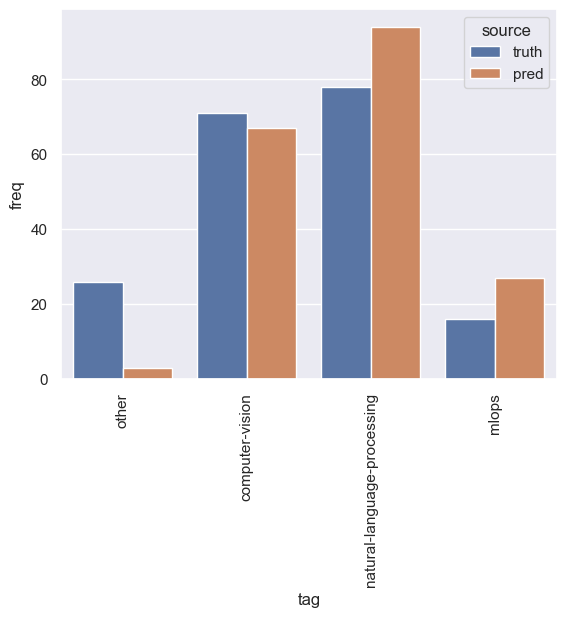

In [22]:
#few shot with gpt 4.1-nano-2025-04-14
method='few_shot'
model='gpt-4.1-nano-2025-04-14'
y_pred[method][model], performance[method][model]=evaluate(test_df=test_df,model=model,system_content=system_content,assistant_content=assistant_content,tags=tags)

100%|██████████| 191/191 [02:22<00:00,  1.34it/s]

{
    "precision": 0.9041964144058385,
    "recall": 0.8429319371727748,
    "f1": 0.8547591208103745
}


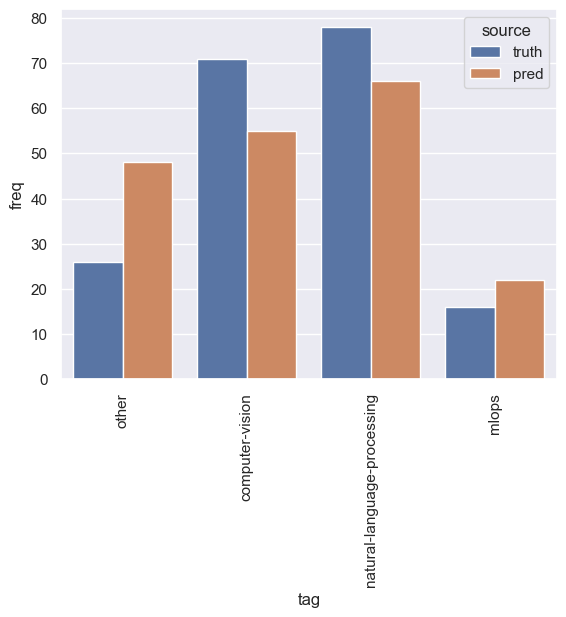

In [23]:
#few shot with gpt 4o-mini
method='few_shot'
model='gpt-4o-mini-2024-07-18'
y_pred[method][model], performance[method][model]=evaluate(test_df=test_df,model=model,system_content=system_content,assistant_content=assistant_content,tags=tags)


Few shot learning performs better than zero-shot counter part, however there is a trade-off between reucing hallucinations and high precision/low recall and f1 score. When GPT 4o mini isn't confident it would rather predict 'other' than predict a label it's not sure about.

#### OSS LLMS
- While the current gold standard for LLMs is closed source, there are many OSS LLMS that are worth checking out.
- The pros of OSS LLMS are:
    - Data ownership meaning you dont have to send the info to the cloud
    - fine tune to your use case
    - optimization via quantization,pruning, etc

#### Results

In [24]:
print(json.dumps(performance,indent=4))

{
    "zero_shot": {
        "gpt-4.1-nano-2025-04-14": {
            "precision": 0.7401770910271409,
            "recall": 0.7905759162303665,
            "f1": 0.7525363836811878
        },
        "gpt-4o-mini-2024-07-18": {
            "precision": 0.9015028524498804,
            "recall": 0.8324607329842932,
            "f1": 0.847166534816448
        }
    },
    "few_shot": {
        "gpt-4.1-nano-2025-04-14": {
            "precision": 0.703363050577075,
            "recall": 0.7801047120418848,
            "f1": 0.7345706788636609
        },
        "gpt-4o-mini-2024-07-18": {
            "precision": 0.9041964144058385,
            "recall": 0.8429319371727748,
            "f1": 0.8547591208103745
        }
    }
}


In [25]:
# Transform data into a new dictionary with four keys
by_model_and_context = {}
for context_type, models_data in performance.items():
    for model, metrics in models_data.items():
        key = f"{model}_{context_type}"
        by_model_and_context[key] = metrics

{'gpt-4.1-nano-2025-04-14_zero_shot': {'precision': 0.7401770910271409, 'recall': 0.7905759162303665, 'f1': 0.7525363836811878}, 'gpt-4o-mini-2024-07-18_zero_shot': {'precision': 0.9015028524498804, 'recall': 0.8324607329842932, 'f1': 0.847166534816448}, 'gpt-4.1-nano-2025-04-14_few_shot': {'precision': 0.703363050577075, 'recall': 0.7801047120418848, 'f1': 0.7345706788636609}, 'gpt-4o-mini-2024-07-18_few_shot': {'precision': 0.9041964144058385, 'recall': 0.8429319371727748, 'f1': 0.8547591208103745}}


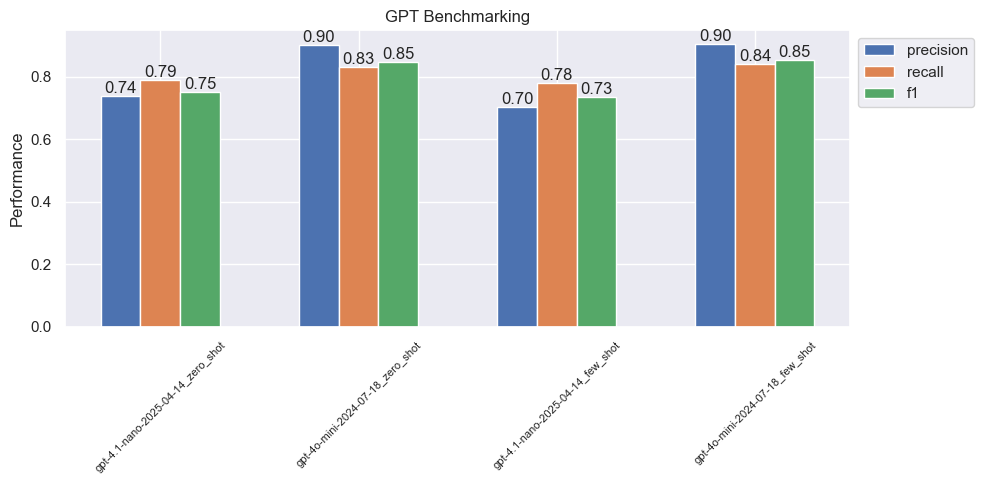

In [ ]:
#extracting the model names and metric values
models=list(by_model_and_context.keys())
print(by_model_and_context)
metrics = list(by_model_and_context[models[0]].keys())

#plotting th bar chart wit metric scores on top of each bar
fig,ax=plt.subplots(figsize=(10,5))
width=0.2
x=range(len(models))

for i,metric in enumerate(metrics):
  metric_values=[by_model_and_context[model][metric] for model in models
  ]
  ax.bar([pos+width*i for pos in x],metric_values,width=width,label=metric)
  for pos,val in enumerate(metric_values):
    ax.text(pos+width*i,val,f"{val:.2f}",ha='center',va='bottom')

ax.set_xticks([pos+width for pos in x])
ax.set_xticklabels(models,rotation=45, ha='center',fontsize=8)
ax.set_ylabel('Performance')
ax.set_title('GPT Benchmarking')
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

### 3.1.2 - Few Shot Learning with fine-tuned models

In [27]:
import os
import random
import torch
from ray.data.preprocessor import Preprocessor
import numpy as np

#### Now fine-tuning

In [28]:
#we'll define a set of seeds and make it reproducible
def set_seeds(seed=1337):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        eval("setattr(torch.backends.cudnn, 'deterministic', True)")
        eval("setattr(torch.backends.cudnn, 'benchmark', False)")
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)   

#### Load Data

- loads data from source (CSV files) and loads it as a ray dataset

In [29]:
import ray
def load_data(num_samples=None):
  ds=ray.data.read_csv(DATASET_LOC)
  ds=ds.random_shuffle(seed=1337)
  ds=ray.data.from_item(ds.take(num_samples)) if num_samples else ds
  return ds

#### Note:
- When working with extremely large datasets, it's good to limit the number of samples in our dataset so that we can execute our code quickly and iterate on bugs, etc. This is why we have a `num_samples` input arg in our `load_data` function

#### Preprocessing Class
- Just for convenience, we'll compose a preprocessor class to process the raw data into something trainable.

In [30]:
class CustomPreprocessor(Preprocessor):
  """Custom preprocessor class."""
  def _fit(self,ds,uniq):
    tags=ds.unique(column=uniq)
    self.class_to_index={tag: i for i, tag in enumerate(tags)}
    self.index_to_class={v:k for k,v in self.class_to_index.items()}
    def _transform_pandas(self,batch): #could also do _transform_numpy
      #this is an inherited function from Preprocessor
      return preprocess(batch,class_to_index=self.class_to_index)

#### Model
Now we're going to start defining our model architecture. We'll start by loading a pretrained LLM and then defining the components needed for fine-tuning it on our dataset. Our pretrained LLM here is a transformer-based model that has been pretrained on a large corpus of scientific text called [scibert](https://huggingface.co/allenai/scibert_scivocab_uncased)
